<a href="https://colab.research.google.com/github/Phillkao/TS/blob/main/TFT_AOI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 28 16:09:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import time
import copy
import pandas as pd

from utils import train_model
from aoi_dataset import aoi_Dataset

### Aoi dataset

In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import zipfile

class aoi_Dataset(Dataset):
    def __init__(self, zip_path, label_path=None, transform=transforms.Compose([transforms.ToTensor()]), phase='train'):
        super(aoi_Dataset, self).__init__()
        self.zip_path = zip_path
        self.label_path = label_path
        self.transform = transform
        self.zip_file = zipfile.ZipFile(zip_path, mode='r')
        self.img_list = []
        for img_name in self.zip_file.namelist():
            if '.jpg' not in img_name or '__MACOSX/' in img_name:
                continue
            self.img_list.append(img_name)
        self.num_img = len(self.img_list)
        if phase == 'train':
            self.label_list = pd.read_csv(label_path)['Label']
        else:
            self.label_list = np.zeros((len(pd.read_csv(label_path)['Label'])))
        self.num_class = 13
        assert len(self.label_list) == self.num_img, print('Length of label and image list must be the same.')
        print('number of image:', self.num_img)
        print('number of class:', self.num_class)

    def __getitem__(self, index):
        with self.zip_file.open(self.img_list[index], mode='r') as img_file:
            img_file = img_file.read()
            img = cv2.imdecode(np.asarray(bytearray(img_file), dtype='uint8'), cv2.IMREAD_GRAYSCALE)
            img = Image.fromarray(img)
        return self.transform(img), self.label_list[index]

    def __len__(self):
        return self.num_img
        
    def get_class_ratio(self):
        return [len(self.label_list[self.label_list==i])/len(self.label_list) for i in range(self.num_class)]

    def close_zip(self):
        self.zip_file.close()


### tripleloss

In [ ]:
class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    
    Reference:
        Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    
    Imported from `<https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py>`_.
    
    Args:
        margin (float, optional): margin for triplet. Default is 0.3.
    """
    
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): feature matrix with shape (batch_size, feat_dim).
            targets (torch.LongTensor): ground truth labels with shape (num_classes).
        """
        n = inputs.size(0)
        
        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        
        # For each anchor, find the hardest positive and negative
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        return self.ranking_loss(dist_an, dist_ap, y)

In [ ]:
train_zip='dataset/train_images.zip'
train_csv='dataset/train.csv'
#train_aug_path = glob.glob('dataset/train/*/*.png')
#print(len(train_aug_path))
#train_aug_csv = 'dataset/train_aug.csv'
batch_size=16
epoch=30

transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor()])

train_set = aoi_Dataset(train_zip, train_csv, transform)
#train_set = aoi_data_aug_Dataset(train_aug_path, train_aug_csv, transform)
[print('class {0}: {1:.1f}%'.format(i, train_set.get_class_ratio()[i]*100)) for i in range(train_set.num_class)]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#model = models.DenseNet(growth_rate=40, block_config=(6, 12, 48, 32), num_init_features=64, num_classes=6)
#model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#model = models.densenet201(pretrained=True)
model = torch.load('after_label_correction.pkl')
#model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)                               
#model.classifier = nn.Linear(in_features=1920, out_features=6, bias=True)

model = model.to(device)

#criterion_ce = nn.CrossEntropyLoss()
#criterion_tp = TripletLoss(margin=1.0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_model_tp(model, criterion_ce, criterion_tp, optimizer, dataloader, scheduler, num_epochs=25, device="cpu"):
    since = time.time()
    
    data_key=['train', 'val']
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in data_key:
            if phase != 'val':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss_ce = 0.0
            running_loss_tp = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase != 'val'):
                    embeds = model.features(inputs)
                    embeds = F.avg_pool2d(embeds, (7, 7)).view(embeds.size(0), -1)
                    outputs = model.classifier(embeds)
                    _, preds = torch.max(outputs, 1)
                    loss_ce = criterion_ce(outputs, labels)
                    loss_tp = criterion_tp(embeds, labels)

                    # backward + optimize only if in training phase
                    if phase != 'val':
                        loss_ce.backward(retain_graph=True)
                        loss_tp.backward()
                        optimizer.step()

                # statistics
                running_loss_ce += loss_ce.item() * inputs.size(0)  
                running_loss_tp += loss_tp.item() * inputs.size(0)                           
                running_corrects += torch.sum(preds == labels.data)
            if phase != 'val':
                scheduler.step()

            epoch_loss_ce = running_loss_ce / len(dataloader.dataset)
            epoch_loss_tp = running_loss_tp / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            del embeds
            print('{} CE Loss: {:.4f} TP Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss_ce, epoch_loss_tp, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        torch.save(model,'checkpoints/'+str(epoch)+'.pkl')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Train Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model = train_model_tp(model, criterion_ce, criterion_tp, optimizer, train_loader,
                       #exp_lr_scheduler, num_epochs=epoch, device=device)

#model = train_model(model, criterion, optimizer, train_loader,
                    #exp_lr_scheduler, num_epochs=epoch, device=device)


## Data cleaning

In [ ]:
%cd /content/drive/MyDrive/TFT

/content/drive/MyDrive/TFT


In [ ]:
import zipfile
import os
import shutil
# reset direntory to new
# 刪除資料夾再重建，如果有直接對裡面的image做過data augmentation小心不要碰到這個cell
# 可以選擇commend掉

# 刪除資料夾(如果資料夾存在，所以使用try/except)
try:
    shutil.rmtree('dataset/train')
except:
    pass
try:
    shutil.rmtree('dataset/test')
except:
    pass
# 建資料夾
os.mkdir('dataset/train')
os.mkdir('dataset/test')
for i in range(13):
    img_dir = os.path.join('dataset/train', str(i))
    os.mkdir(img_dir)

In [ ]:
# unzip train images
# 對訓練資料做解壓縮，然後分class儲存在不同資料夾
zip_path = 'dataset/train.zip'
label_path = 'dataset/train.csv'
# unzip file
zip_file = zipfile.ZipFile('dataset/train.zip', mode='r')
img_list = []
# append name into a list
for img_name in zip_file.namelist():
    if '.jpg' not in img_name or '__MACOSX/' in img_name:
        continue
    img_list.append(img_name)
num_img = len(img_list)
# store label into a list
label_list = pd.read_csv(label_path)['Label']
num_class = 1 + np.max(label_list)
print('number of train image:', num_img)
print('number of class:', num_class)

number of train image: 104000
number of class: 13


In [ ]:
for i in range(len(img_list)):
    # 讓zip開啟檔案 然後解碼成numpy array
    with zip_file.open(img_list[i], mode='r') as img_file:
        img_file = img_file.read()
        img = cv2.imdecode(np.asarray(bytearray(img_file), dtype='uint8'), cv2.IMREAD_GRAYSCALE)
    label = label_list[i]
    store_path = os.path.join('dataset/train', str(label))
    store_path = os.path.join(store_path, img_list[i].split('/')[-1])
    cv2.imwrite(store_path, img)

number of image: 104000
number of class: 13


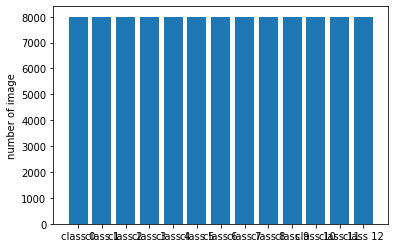

In [ ]:
# visualize number of images in each class 
import matplotlib.pyplot as plt

train_zip='dataset/train.zip'
train_csv='dataset/train.csv'
train_set = aoi_Dataset(train_zip, train_csv)
x = [(train_set.get_class_ratio()[i])*104000 for i in range(train_set.num_class)]
names = ['class {0}'.format(i) for i in range(train_set.num_class)]
plt.bar(names ,x)
plt.ylabel('number of image')
plt.show()

### Aug

In [ ]:
from PIL import Image
from PIL import ImageEnhance
import random
import zipfile
import os

# 增加每個class的圖片數量至全部class的圖片數量一致

label_name = range(1, 13, 1)
for i in range(1,len(label_name)+1):
  path = 'dataset/train'+'/'+str(i)
  # add number of images as same as class 0 (amount of images in class0 is biggest) 
  for img in os.listdir(path):
    save_name = os.path.join(path, 'pad_'+img)
    save_bri_name = os.path.join(path, 'bri_'+img)
    save_con_name = os.path.join(path, 'con_'+img)
    img = cv2.imdecode(np.asarray(bytearray(img_file), dtype='uint8'), cv2.IMREAD_GRAYSCALE)
    img = Image.fromarray(img)
    image_pad = np.pad(img, pad_width=50, mode='symmetric')
    nh = random.randint(0, image_pad.shape[0]-512)
    nw = random.randint(0, image_pad.shape[1]-512)
    image_crop = image_pad[nh:nh+512, nw:nw+512]
    image_crop = Image.fromarray(np.uint8(image_crop))
    enh_bri = ImageEnhance.Brightness(img)
    enh_con = ImageEnhance.Contrast(img)
    brightness = random.uniform(0.5, 10)
    contrast = random.uniform(0.5, 10)
    img_bri = enh_bri.enhance(brightness)
    img_con = enh_con.enhance(contrast)
    if x[0]>len(os.listdir(path)):
      image_crop.save(save_name)
    if x[0]>len(os.listdir(path)):
      img_bri.save(save_bri_name)
    if x[0]>len(os.listdir(path)):
      img_con.save(save_con_name)

"\nlabel_name = [1,2,3,4,5]\nfor i in range(1,len(label_name)+1):\n  path = 'dataset/train'+'/'+str(i)\n  # add number of images as same as class 0 (amount of images in class0 is biggest) \n  for img in os.listdir(path):\n    save_name = os.path.join(path, 'pad_'+img)\n    save_bri_name = os.path.join(path, 'bri_'+img)\n    save_con_name = os.path.join(path, 'con_'+img)\n    img = cv2.imdecode(np.asarray(bytearray(img_file), dtype='uint8'), cv2.IMREAD_GRAYSCALE)\n    img = Image.fromarray(img)\n    image_pad = np.pad(img, pad_width=50, mode='symmetric')\n    nh = random.randint(0, image_pad.shape[0]-512)\n    nw = random.randint(0, image_pad.shape[1]-512)\n    image_crop = image_pad[nh:nh+512, nw:nw+512]\n    image_crop = Image.fromarray(np.uint8(image_crop))\n    enh_bri = ImageEnhance.Brightness(img)\n    enh_con = ImageEnhance.Contrast(img)\n    brightness = random.uniform(0.5, 10)\n    contrast = random.uniform(0.5, 10)\n    img_bri = enh_bri.enhance(brightness)\n    img_con = enh_

### check balence

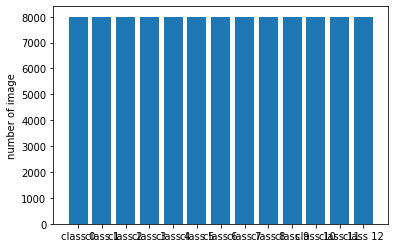

In [ ]:
for i in range(train_set.num_class):
  path = 'dataset/train'+'/'+str(i)
names = ['class {0}'.format(i) for i in range(train_set.num_class)]
plt.bar(names ,len(os.listdir(path)))
plt.ylabel('number of image')
plt.show()

In [ ]:
names

['class 0',
 'class 1',
 'class 2',
 'class 3',
 'class 4',
 'class 5',
 'class 6',
 'class 7',
 'class 8',
 'class 9',
 'class 10',
 'class 11',
 'class 12']

In [ ]:
import glob
from aoi_aug_dataset import aoi_data_aug_Dataset

In [ ]:
train_zip='dataset/train.zip'
train_csv='dataset/train.csv'
#train_aug_path = glob.glob('dataset/train/*/*.png')
#train_aug_csv = 'dataset/train_aug.csv'
batch_size=32
epoch=30

transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor()])

train_set = aoi_Dataset(train_zip, train_csv, transform)
#train_set = aoi_data_aug_Dataset(train_aug_path, train_aug_csv, transform)
[print('class {0}: {1:.1f}%'.format(i, train_set.get_class_ratio()[i]*100)) for i in range(train_set.num_class)]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#model = models.DenseNet(growth_rate=40, block_config=(6, 12, 48, 32), num_init_features=64, num_classes=6)
#model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = models.densenet201(pretrained=True)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)                               

model = model.to(device)

#criterion_ce = nn.CrossEntropyLoss()
#criterion_tp = nn.TripletMarginLoss(margin=1.0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model = train_model(model, criterion, optimizer, train_loader,
                    exp_lr_scheduler, num_epochs=epoch, device=device)

number of image: 104000
number of class: 13
class 0: 7.7%
class 1: 7.7%
class 2: 7.7%
class 3: 7.7%
class 4: 7.7%
class 5: 7.7%
class 6: 7.7%
class 7: 7.7%
class 8: 7.7%
class 9: 7.7%
class 10: 7.7%
class 11: 7.7%
class 12: 7.7%


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

Epoch 0/29
----------


KeyboardInterrupt: ignored

In [ ]:
from utils import test_model 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from aoi_dataset import aoi_Dataset
                                                                                         # test and give prediction
for epoch in range(10, 30):
    model = torch.load('checkpoints/'+str(epoch)+'.pkl')
    test_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor()])
    test_set = aoi_Dataset('dataset/test_images.zip', 'dataset/test.csv', test_transform, phase='test')
    test_loader = DataLoader(test_set, batch_size=8, pin_memory=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pred = test_model(model, test_loader, label_csv='dataset/test.csv', device=device, ep=epoch)

number of image: 10142
number of class: 6


/content/drive/Shared drives/Machine Learning/utils.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'][batch_pos+i] = int(preds[i])


number of image: 10142
number of class: 6


/content/drive/Shared drives/Machine Learning/utils.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'][batch_pos+i] = int(preds[i])


number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6
number of image: 10142
number of class: 6


In [ ]:
class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    
    Reference:
        Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    
    Imported from `<https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py>`_.
    
    Args:
        margin (float, optional): margin for triplet. Default is 0.3.
    """
    
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): feature matrix with shape (batch_size, feat_dim).
            targets (torch.LongTensor): ground truth labels with shape (num_classes).
        """
        n = inputs.size(0)
        
        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        
        # For each anchor, find the hardest positive and negative
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        return self.ranking_loss(dist_an, dist_ap, y)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from aoi_dataset import aoi_Dataset

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

dataset = aoi_Dataset('dataset/train_images.zip', 'dataset/train.csv', transform, phase='train')
dataloader = DataLoader(dataset, batch_size=16, pin_memory=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torch.load('after_label_correction.pkl')
model = model.to(device)

criterion_ce = nn.CrossEntropyLoss()
#criterion_tp = TripletLoss(margin=1.0)

running_loss_ce = 0
running_loss_tp = 0
running_correct = 0

# load model
epochs = 1

for epoch in range(epochs):
    for i, (img, label) in enumerate(dataloader):
        model.eval()

        img = img.cuda()
        label = label.cuda()

        embed = model.features(img)
        embed = F.avg_pool2d(embed, (7, 7)).view(embed.size(0), -1)
        out = model.classifier(embed)
        _, pred = torch.max(out, 1)


        #loss_ce = criterion_ce(out, label.type(torch.cuda.LongTensor))
        #loss_tp = criterion_tp(embed, label)

        #running_loss_ce += loss_ce.item() * img.size(0)    
        #running_loss_tp += loss_tp.item() * img.size(0)                         
        #running_correct += torch.sum(pred == label.data)

        eb = embed.detach().cpu().numpy()
        label = label.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        if i == 0:
            feature = eb
            labels = label
            #preds = pred
        else:
            feature = np.concatenate((feature, eb))
            labels = np.concatenate((labels, label))
            #preds = np.concatenate((preds, pred))
        del embed
    #epoch_loss_ce = running_loss_ce / len(dataloader.dataset)
    #epoch_loss_tp = running_loss_tp / len(dataloader.dataset)
    #epoch_acc = running_correct.double() / len(dataloader.dataset)
    #print('{} Cross Entropy Loss: {:.4f} Triplet Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss_ce, epoch_loss_tp, epoch_acc))

number of image: 2528
number of class: 6


In [ ]:
test_feature = feature.copy()

In [ ]:
train_feature = feature.copy()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
feature = np.concatenate((train_feature, test_feature))
tran = tsne.fit_transform(feature)
tran.shape

(12670, 2)

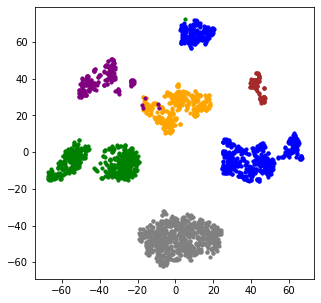

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(tran[labels==0,0], tran[labels==0,1], s=10, c='blue')
plt.scatter(tran[labels==1,0], tran[labels==1,1], s=10, c='green')
plt.scatter(tran[labels==2,0], tran[labels==2,1], s=10, c='brown')
plt.scatter(tran[labels==3,0], tran[labels==3,1], s=10, c='orange')
plt.scatter(tran[labels==4,0], tran[labels==4,1], s=10, c='purple')
plt.scatter(tran[labels==5,0], tran[labels==5,1], s=10, c='gray')

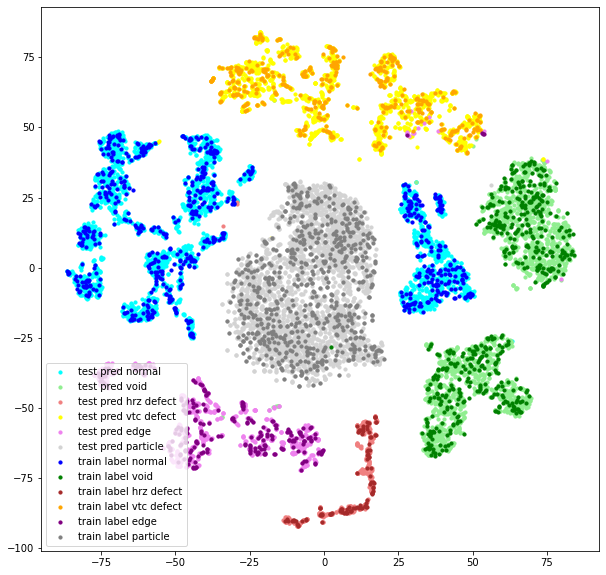

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(tran[train_feature.shape[0]:,0][preds==0], tran[train_feature.shape[0]:,1][preds==0], s=10, c='cyan', label='test pred normal')
plt.scatter(tran[train_feature.shape[0]:,0][preds==1], tran[train_feature.shape[0]:,1][preds==1], s=10, c='lightgreen', label='test pred void')
plt.scatter(tran[train_feature.shape[0]:,0][preds==2], tran[train_feature.shape[0]:,1][preds==2], s=10, c='lightcoral', label='test pred hrz defect')
plt.scatter(tran[train_feature.shape[0]:,0][preds==3], tran[train_feature.shape[0]:,1][preds==3], s=10, c='yellow', label='test pred vtc defect')
plt.scatter(tran[train_feature.shape[0]:,0][preds==4], tran[train_feature.shape[0]:,1][preds==4], s=10, c='violet', label='test pred edge')
plt.scatter(tran[train_feature.shape[0]:,0][preds==5], tran[train_feature.shape[0]:,1][preds==5], s=10, c='lightgray', label='test pred particle')

plt.scatter(tran[:train_feature.shape[0],0][labels==0], tran[:train_feature.shape[0],1][labels==0], s=10, c='blue', label='train label normal')
plt.scatter(tran[:train_feature.shape[0],0][labels==1], tran[:train_feature.shape[0],1][labels==1], s=10, c='green', label='train label void')
plt.scatter(tran[:train_feature.shape[0],0][labels==2], tran[:train_feature.shape[0],1][labels==2], s=10, c='brown', label='train label hrz defect')
plt.scatter(tran[:train_feature.shape[0],0][labels==3], tran[:train_feature.shape[0],1][labels==3], s=10, c='orange', label='train label vtc defect')
plt.scatter(tran[:train_feature.shape[0],0][labels==4], tran[:train_feature.shape[0],1][labels==4], s=10, c='purple', label='train label edge')
plt.scatter(tran[:train_feature.shape[0],0][labels==5], tran[:train_feature.shape[0],1][labels==5], s=10, c='gray', label='train label particle')

plt.legend(loc='lower left')

In [ ]:
np.save('train_features.npy', tran[:train_feature.shape[0]])
np.save('test_features.npy', tran[train_feature.shape[0]:])

## Label Correction 確認資料集分類是否"完全"正確

In [ ]:
# preform KNN on train data


array([0, 1, 1, ..., 3, 0, 5])

In [ ]:
fea = torch.Tensor(tran[:train_feature.shape[0]])
n = fea.size(0)
dist = torch.pow(fea, 2).sum(dim=1, keepdim=True).expand(n, n)
dist = dist + dist.t()
dist.addmm_(1, -2, fea, fea.t())
sort_dist = np.argsort(np.array(dist), axis=1)[:, 1:4]

anomaly_node = []
anomaly_label = []
anomaly_near = []
for i in range(n):
    diff = 0
    near = []
    for j in range(3):
        near.append(labels[sort_dist[i, j]])
        if labels[i] != labels[sort_dist[i, j]]:
            diff += 1
    if diff > 0:
        print(i)
        print(labels[i])
        print(near)
        print()
        anomaly_node.append(i)
        anomaly_label.append(labels[i])
        anomaly_near.append(near)
anomaly_node = np.array(anomaly_node)

257
4
[3, 3, 3]

507
3
[4, 3, 4]

540
4
[4, 3, 3]

908
1
[5, 5, 5]

2015
4
[4, 3, 3]

2122
5
[1, 5, 5]

2268
3
[3, 4, 3]

2506
3
[4, 3, 3]



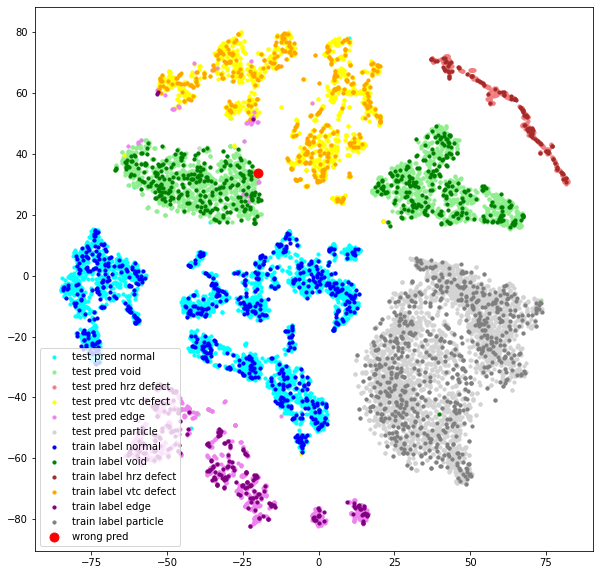

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(tran[train_feature.shape[0]:,0][preds==0], tran[train_feature.shape[0]:,1][preds==0], s=10, c='cyan', label='test pred normal')
plt.scatter(tran[train_feature.shape[0]:,0][preds==1], tran[train_feature.shape[0]:,1][preds==1], s=10, c='lightgreen', label='test pred void')
plt.scatter(tran[train_feature.shape[0]:,0][preds==2], tran[train_feature.shape[0]:,1][preds==2], s=10, c='lightcoral', label='test pred hrz defect')
plt.scatter(tran[train_feature.shape[0]:,0][preds==3], tran[train_feature.shape[0]:,1][preds==3], s=10, c='yellow', label='test pred vtc defect')
plt.scatter(tran[train_feature.shape[0]:,0][preds==4], tran[train_feature.shape[0]:,1][preds==4], s=10, c='violet', label='test pred edge')
plt.scatter(tran[train_feature.shape[0]:,0][preds==5], tran[train_feature.shape[0]:,1][preds==5], s=10, c='lightgray', label='test pred particle')

plt.scatter(tran[:train_feature.shape[0],0][labels==0], tran[:train_feature.shape[0],1][labels==0], s=10, c='blue', label='train label normal')
plt.scatter(tran[:train_feature.shape[0],0][labels==1], tran[:train_feature.shape[0],1][labels==1], s=10, c='green', label='train label void')
plt.scatter(tran[:train_feature.shape[0],0][labels==2], tran[:train_feature.shape[0],1][labels==2], s=10, c='brown', label='train label hrz defect')
plt.scatter(tran[:train_feature.shape[0],0][labels==3], tran[:train_feature.shape[0],1][labels==3], s=10, c='orange', label='train label vtc defect')
plt.scatter(tran[:train_feature.shape[0],0][labels==4], tran[:train_feature.shape[0],1][labels==4], s=10, c='purple', label='train label edge')
plt.scatter(tran[:train_feature.shape[0],0][labels==5], tran[:train_feature.shape[0],1][labels==5], s=10, c='gray', label='train label particle')

#k = 0
#plt.scatter(tran[anomaly_node[k],0], tran[anomaly_node[k],1], s=80, c='red', label='anomaly node')

plt.scatter(tran[:train_feature.shape[0],0][train_pred!=labels], tran[:train_feature.shape[0],1][train_pred!=labels], s=80, c='red', label='wrong pred')

plt.legend(loc='lower left')

number of image: 2528
number of class: 6


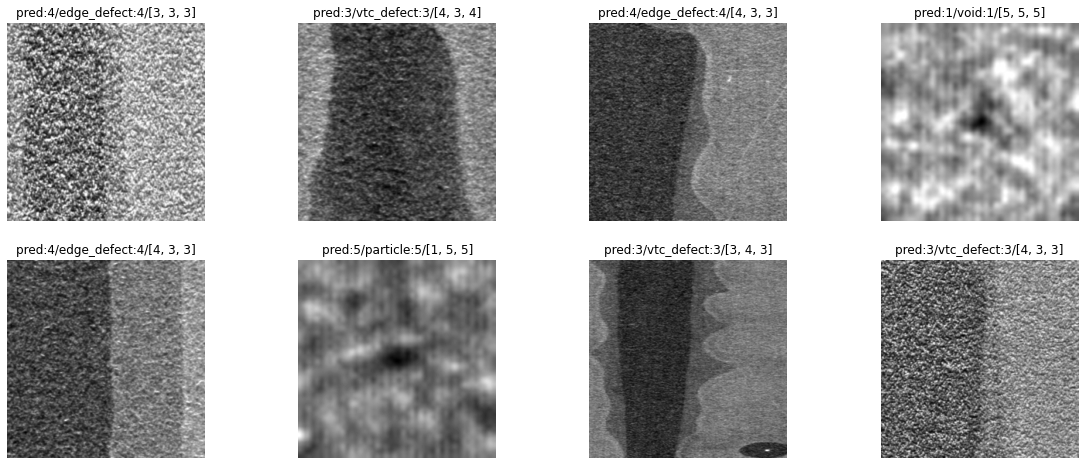

In [ ]:
class_name = ['normal', 'void', 'hrz_defect', 'vtc_defect', 'edge_defect', 'particle']
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224)])
dataset = aoi_Dataset('dataset/train_images.zip', 'dataset/train.csv', transform, phase='train')
plt.figure(figsize=(20, 8))
for idx, i in enumerate(anomaly_node):
    plt.subplot(2,4,idx+1)
    plt.axis('off')
    plt.imshow(dataset[i][0], cmap='gray')
    plt.title('pred:'+str(train_pred[i])+'/'+class_name[labels[i]]+':'+str(labels[i])+'/'+str(anomaly_near[idx]))

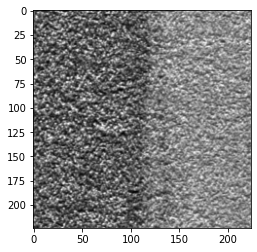

In [ ]:
plt.imshow(dataset[anomaly_node[7]][0], cmap='gray')

In [ ]:
labels.shape

(2528,)

In [ ]:
train_pred.shape

(2528,)

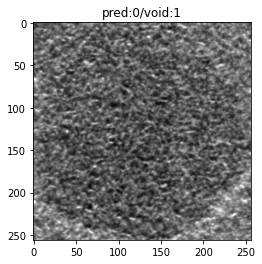

In [ ]:
# wrong prediction
i = np.where(train_pred!=labels)[0][0]
plt.title('pred:'+str(train_pred[i])+'/'+class_name[labels[i]]+':'+str(labels[i]))
plt.imshow(dataset[i][0], cmap='gray')

In [ ]:
i

1569